In [1]:
from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter
from lifelines.utils import concordance_index
from lifelines.plotting import add_at_risk_counts
from lifelines.statistics import pairwise_logrank_test
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns
from skbio.stats.composition import clr
from sklearn.preprocessing import normalize
from sklearn.utils import resample
import time

import warnings
warnings.filterwarnings("ignore", message="FutureWarning")

import sys
main_path = '/nfs/home/users/krakovic/sharedscratch/Histomorphological-Phenotype-Learning/'
sys.path.append(main_path)
# from models.clustering.cox_proportional_hazard_regression_leiden_clusters import *

sys.path.append('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/libraries')
from survival import *
from clinical import load_clinical
from data_processing import *
from forest_plots import *

In [2]:
iaslc_grade = pd.read_csv('/mnt/cephfs/sharedscratch/users/krakovic/Histomorphological-Phenotype-Learning/results/BarlowTwins_3/LATTICeA_5x/h224_w224_n3_zdim128_filtered/rapids_2p5m/rapids_2p5m_leiden_2.5_l1ratio_0_mintiles_100_os_event_ind_20241127_123050_IASLC_grade/c_indexes.csv', index_col=0)
iaslc_grade = pd.melt(iaslc_grade, id_vars=['fold', 'alpha'], var_name='Set', value_vars=['train', 'test', 'additional'], value_name='c_index')
iaslc_grade['model'] = 'IASLC Grade'
# iaslc_grade = iaslc_grade[iaslc_grade['alpha'] == 0.0001]

tumour = pd.read_csv('/mnt/cephfs/sharedscratch/users/krakovic/Histomorphological-Phenotype-Learning/results/BarlowTwins_3/LATTICeA_5x/h224_w224_n3_zdim128_filtered/rapids_2p5m/rapids_2p5m_leiden_2.5_l1ratio_0p2_mintiles_100_os_event_ind_20241126_17335_new_tumour_HPL_vectors/c_indexes.csv', index_col=0)
tumour = pd.melt(tumour, id_vars=['fold', 'alpha'], var_name='Set', value_vars=['train', 'test', 'additional'], value_name='c_index')
tumour['model'] = r'$HPL_{Tumour}$'
# tumour = tumour[tumour['alpha'] == ]

stroma = pd.read_csv('/mnt/cephfs/sharedscratch/users/krakovic/Histomorphological-Phenotype-Learning/results/BarlowTwins_3/LATTICeA_5x/h224_w224_n3_zdim128_filtered/rapids_2p5m/rapids_2p5m_leiden_2.5_l1ratio_0p2_mintiles_100_os_event_ind_20241126_174844_new_stroma_HPL_vectors/c_indexes.csv', index_col=0)
stroma = pd.melt(stroma, id_vars=['fold', 'alpha'], var_name='Set', value_vars=['train', 'test', 'additional'], value_name='c_index')
stroma['model'] = r'$HPL_{Stroma}$'

tum_stroma = pd.read_csv('/mnt/cephfs/sharedscratch/users/krakovic/Histomorphological-Phenotype-Learning/results/BarlowTwins_3/LATTICeA_5x/h224_w224_n3_zdim128_filtered/rapids_2p5m/rapids_2p5m_leiden_2.5_l1ratio_0p2_mintiles_100_os_event_ind_20241126_155025_all_abnormal_HPL_vectors/c_indexes.csv', index_col=0)
tum_stroma = pd.melt(tum_stroma, id_vars=['fold', 'alpha'], var_name='Set', value_vars=['train', 'test', 'additional'], value_name='c_index')
tum_stroma['model'] = r'$HPL_{Tumour + Stroma}$'

tumour_grade = pd.read_csv('/mnt/cephfs/sharedscratch/users/krakovic/Histomorphological-Phenotype-Learning/results/BarlowTwins_3/LATTICeA_5x/h224_w224_n3_zdim128_filtered/rapids_2p5m/rapids_2p5m_leiden_2.5_l1ratio_0_mintiles_100_os_event_ind_20241127_135526_grade_and_tumour/c_indexes.csv', index_col=0)
tumour_grade = pd.melt(tumour_grade, id_vars=['fold', 'alpha'], var_name='Set', value_vars=['train', 'test', 'additional'], value_name='c_index')
tumour_grade['model'] = r'$HPL_{Tumour}$' + f'+\nIASLC Grade'
# tumour_grade = tumour_grade[tumour_grade['alpha'] == 0.3906939937054613]

stroma_grade = pd.read_csv('/mnt/cephfs/sharedscratch/users/krakovic/Histomorphological-Phenotype-Learning/results/BarlowTwins_3/LATTICeA_5x/h224_w224_n3_zdim128_filtered/rapids_2p5m/rapids_2p5m_leiden_2.5_l1ratio_0_mintiles_100_os_event_ind_20241127_13208_grade_and_stroma/c_indexes.csv', index_col=0)
stroma_grade = pd.melt(stroma_grade, id_vars=['fold', 'alpha'], var_name='Set', value_vars=['train', 'test', 'additional'], value_name='c_index')
stroma_grade['model'] = r'$HPL_{Stroma}$' + f'+\nIASLC Grade'

# all_hpl_grade = pd.read_csv('/mnt/cephfs/sharedscratch/users/krakovic/Histomorphological-Phenotype-Learning/results/BarlowTwins_3/LATTICeA_5x/h224_w224_n3_zdim128_filtered/rapids_2p5m/rapids_2p5m_leiden_2.5_l1ratio_0_mintiles_100_os_event_ind_20241121_15215_new_all_abnormal_and_grade/c_indexes.csv', index_col=0)
# all_hpl_grade = pd.melt(all_hpl_grade, id_vars=['fold', 'alpha'], var_name='Set', value_vars=['train', 'test', 'additional'], value_name='c_index')
# all_hpl_grade['model'] = r'$HPL_{Tumour + Stroma}$' + f'+\nIASLC Grade'

In [3]:
tumour_grade[tumour_grade['Set'] == 'test']['c_index'].std()

0.03972900385534702

In [5]:
c_ind_frame = pd.concat([iaslc_grade, tumour, stroma, tum_stroma, tumour_grade, stroma_grade])
# c_ind_frame = pd.concat([iaslc_grade, tumour, stroma, tum_stroma, tumour_grade, stroma_grade, all_hpl_grade])
c_ind_frame['Set'] = c_ind_frame['Set'].apply(lambda x: x.capitalize())
c_ind_frame = c_ind_frame.replace({'Additional':'TCGA'})

c_ind_frame

,fold,alpha,Set,c_index,model
0,0,0.0001,Train,0.590801,IASLC Grade
1,1,0.0001,Train,0.581436,IASLC Grade
2,2,0.0001,Train,0.566437,IASLC Grade
3,3,0.0001,Train,0.601448,IASLC Grade
4,4,0.0001,Train,0.587266,IASLC Grade
...,...,...,...,...,...
745,0,10000.0000,TCGA,0.625803,$HPL_{Stroma}$+\nIASLC Grade
746,1,10000.0000,TCGA,0.618039,$HPL_{Stroma}$+\nIASLC Grade
747,2,10000.0000,TCGA,0.623161,$HPL_{Stroma}$+\nIASLC Grade
748,3,10000.0000,TCGA,0.624380,$HPL_{Stroma}$+\nIASLC Grade


/tmp/ipykernel_2370394/1516088875.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30)


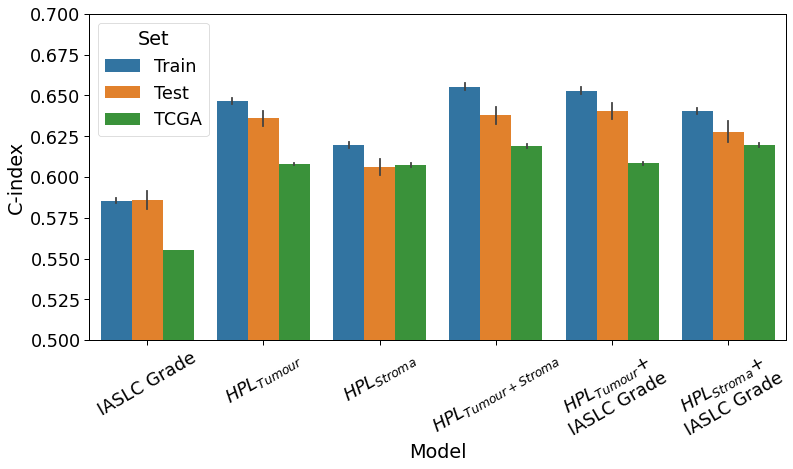

In [12]:
sns.set_context("paper", font_scale=2.0)
fig, ax = plt.subplots(figsize=(12.5,6))
sns.barplot(data = c_ind_frame, x = 'model', y = 'c_index', hue = 'Set', ax=ax)
# sns.pointplot(data = c_ind_frame, x = 'model', y = 'c_index', hue = 'Set', join=False, dodge=0.5, scale=2.0, capsize=0.2, errwidth=4.0, errorbar='sd', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax.set_ylim([0.5,0.7])
ax.set_ylabel('C-index')
ax.set_xlabel('Model')
plt.savefig('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/survival/250707_barplot_c_index.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

In [6]:
c_ind_frame

,fold,alpha,Set,c_index,model
0,0,0.0001,Train,0.590801,IASLC Grade
1,1,0.0001,Train,0.581436,IASLC Grade
2,2,0.0001,Train,0.566437,IASLC Grade
3,3,0.0001,Train,0.601448,IASLC Grade
4,4,0.0001,Train,0.587266,IASLC Grade
...,...,...,...,...,...
745,0,10000.0000,TCGA,0.625803,$HPL_{Stroma}$+\nIASLC Grade
746,1,10000.0000,TCGA,0.618039,$HPL_{Stroma}$+\nIASLC Grade
747,2,10000.0000,TCGA,0.623161,$HPL_{Stroma}$+\nIASLC Grade
748,3,10000.0000,TCGA,0.624380,$HPL_{Stroma}$+\nIASLC Grade


/tmp/ipykernel_1237220/454930728.py:6: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(data = c_ind_frame_tum_only, x = 'model', y = 'c_index', hue = 'Set', join=False, dodge=0.5, scale=2.0, capsize=0.2, errwidth=4.0, errorbar='sd', ax=ax)
/tmp/ipykernel_1237220/454930728.py:6: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data = c_ind_frame_tum_only, x = 'model', y = 'c_index', hue = 'Set', join=False, dodge=0.5, scale=2.0, capsize=0.2, errwidth=4.0, errorbar='sd', ax=ax)
/tmp/ipykernel_1237220/454930728.py:6: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 4.0}` instead.

  sns.pointplot(data = c_ind_frame_tum_only, x = 'mod

Text(0.5, 0, '')

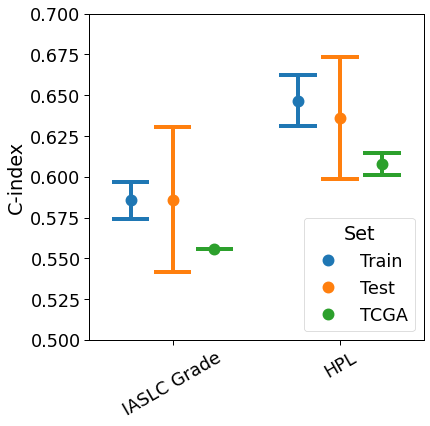

In [11]:
c_ind_frame_tum_only = c_ind_frame[c_ind_frame['model'].isin(['IASLC Grade', r'$HPL_{Tumour}$'])]
c_ind_frame_tum_only = c_ind_frame_tum_only.replace({r'$HPL_{Tumour}$':'HPL'})

sns.set_context("paper", font_scale=2.0)
fig, ax = plt.subplots(figsize=(6,6))
sns.pointplot(data = c_ind_frame_tum_only, x = 'model', y = 'c_index', hue = 'Set', join=False, dodge=0.5, scale=2.0, capsize=0.2, errwidth=4.0, errorbar='sd', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax.set_ylim([0.5,0.7])
ax.set_ylabel('C-index')
ax.set_xlabel(None)

In [23]:
avg_ci_frame = pd.DataFrame(index = c_ind_frame['model'].unique(), columns=['Train', 'Test', 'Additional'])

for model in c_ind_frame['model'].unique():
    model_frame = c_ind_frame[c_ind_frame['model'] == model]
    avg_ci_frame.loc[model, 'Train'] = np.round(model_frame.groupby('Set')['c_index'].mean().loc['Train'], 3)
    avg_ci_frame.loc[model, 'Test'] = np.round(model_frame.groupby('Set')['c_index'].mean().loc['Test'], 3)
    avg_ci_frame.loc[model, 'Additional'] = np.round(model_frame.groupby('Set')['c_index'].mean().loc['Additional'], 3)

avg_ci_frame = avg_ci_frame.rename(columns={'Additional':'TCGA'}).reset_index()
avg_ci_frame = avg_ci_frame.rename(columns={'index':'Model'})
avg_ci_frame

,Model,Train,Test,TCGA
0,IASLC Grade,0.585,0.586,0.555
1,$HPL_{Tumour}$,0.647,0.636,0.608
2,$HPL_{Stroma}$,0.62,0.606,0.607
3,$HPL_{Tumour + Stroma}$,0.655,0.638,0.619
4,$HPL_{Tumour}$+\nIASLC Grade,0.653,0.641,0.608
5,$HPL_{Stroma}$+\nIASLC Grade,0.64,0.628,0.62


In [28]:
from great_tables import GT

summary_gt = (
    GT(avg_ci_frame)
    # .tab_stub(rowname_col='Characteristic', groupname_col='group')
    .tab_stubhead(label='Model')
    .tab_header(title='Mean C-index across folds')
    .tab_options(stub_row_group_font_weight=1000)
)

summary_gt

GT(_tbl_data=                          Model  Train   Test   TCGA
0                   IASLC Grade  0.585  0.586  0.555
1                $HPL_{Tumour}$  0.647  0.636  0.608
2                $HPL_{Stroma}$   0.62  0.606  0.607
3       $HPL_{Tumour + Stroma}$  0.655  0.638  0.619
4  $HPL_{Tumour}$+\nIASLC Grade  0.653  0.641  0.608
5  $HPL_{Stroma}$+\nIASLC Grade   0.64  0.628   0.62, _body=<great_tables._gt_data.Body object at 0x7ff3fc3f75e0>, _boxhead=Boxhead([ColInfo(var='Model', type=<ColInfoTypeEnum.default: 1>, column_label='Model', column_align='left', column_width=None), ColInfo(var='Train', type=<ColInfoTypeEnum.default: 1>, column_label='Train', column_align='right', column_width=None), ColInfo(var='Test', type=<ColInfoTypeEnum.default: 1>, column_label='Test', column_align='right', column_width=None), ColInfo(var='TCGA', type=<ColInfoTypeEnum.default: 1>, column_label='TCGA', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7ff3fc53bf70>, _spanners=Spanners([]), _heading=Heading(title='Mean C-index across folds', subtitle=None, preheader=None), _stubhead='Model', _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x7ff3fc3f4670>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_bottom_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_bottom_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_bottom_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_left_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_left_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_left_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), heading_back

In [25]:
# print(summary_gt.as_raw_html())
# print(summary_gt.as_latex(use_longtable=True))
print(summary_gt.as_latex())

\begin{table}[!t]
\caption*{
{\large Mean C-index across folds}
} 

\fontsize{12.0pt}{14.4pt}\selectfont

\begin{tabular*}{\linewidth}{@{\extracolsep{\fill}}lrrr}
\toprule
Model & Train & Test & TCGA \\ 
\midrule\addlinespace[2.5pt]
IASLC Grade & 0.585 & 0.586 & 0.555 \\
\$HPL\_\{Tumour\}\$ & 0.647 & 0.636 & 0.608 \\
\$HPL\_\{Stroma\}\$ & 0.62 & 0.606 & 0.607 \\
\$HPL\_\{Tumour + Stroma\}\$ & 0.655 & 0.638 & 0.619 \\
\$HPL\_\{Tumour\}\$+
IASLC Grade & 0.653 & 0.641 & 0.608 \\
\$HPL\_\{Stroma\}\$+
IASLC Grade & 0.64 & 0.628 & 0.62 \\
\bottomrule
\end{tabular*}

\end{table}

